# **FPT Models - Return models**

Review:
- Return is close to normal distribution with somewhat heavy tails.
- Return is stationary (both unit root and trend).
- There is volatility clustering (High autocorrelation in squared return)
- There is momentum (High autocorrelation in return lag 1)

#### **I. Imports and Load**

In [1]:
# Imports
# General
import numpy as np
import pandas as pd
import datetime
import math
import os
import sys
import random

# Preprocess

# Models
import statsmodels.api as sm
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
#import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Utils
sys.path.append(os.path.abspath('..'))
from src.utils.get_data import get_stock
from src.metrics.risk import qlike
from src.preprocess.data_transform import make_lags, make_shocks
from src.preprocess.split import purge_kfold_split
from src.models.risk import ARCH_MD, GARCH_MD
from src.models.decision import price_volatility

d:\workplace\Project\stock_analyst\sa_env\Lib\site-packages\vnai\scope\profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Configs
np.random.seed(42)
#tf.random.set_seed(42)
NUM_DAYS_YEAR = 252
START_DATE = '2007-01-01'
END_DATE = '2025-09-01'
#END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

In [3]:
# Load data
df = get_stock('FPT', START_DATE, END_DATE)
df.shape

(4650, 8)

#### **II. Preprocess**

In [4]:
# Add squared return
df['squared_return'] = df['return']**2
df.head(1)

,time,open,high,low,close,volume,return,log_return,squared_return
1,2007-01-03,10.85,11.09,10.85,11.09,74660,0.02212,0.021879,0.000489


In [5]:
df.reset_index(inplace=True)
df.head(1)

,index,time,open,high,low,close,volume,return,log_return,squared_return
0,1,2007-01-03,10.85,11.09,10.85,11.09,74660,0.02212,0.021879,0.000489


#### **III. Choosing metrics**

- For return model: 
  + The return distribution is fat tailed with a few extreme value but meaningful, use MAE so the extreme value does not overwhelm the evaluation while still keep somewhat of it information.
  + RMSE good for large mistake (risk management) but may not be stable or driven toward extreme values.
  + Also evaluate direction accuracy of the model, since the return is highly close to 0 most of the time and so is the mean, direction would be a good differentiate when MAE can not estimate between close but wrong signs true and predicted value.  
  => Since sign estimating is important, and mean is close to 0, RMSE would be bad since it penalizes extreme value misprediction and may drive the whole evaluation toward it. This lead to possible bias result toward negative or postive (whichever has larger extreme values).  
  => To evaluate return model: MAE + direction accuracy

- For votality model:
  + QLike
  + Log-likelihood for select GARCH models.

#### **IV. Return models**

a, Baseline model

Whitenoise:  
rt = u + et, et ~ N(0, s**2)  
  
Forcast:  
- Return: rt = u (mean)
- Volatility, constant: s**2

In [6]:
# Return
r_bl = df['return'].mean()
var_bl = df['return'].std()**2

print('Baseline return: ', r_bl)
print('Baseline variance: ', var_bl)

Baseline return:  0.0006652994847010489
Baseline variance:  0.00036864673674661145


In [7]:
y_pred_bl = np.ones(df['return'].shape) * r_bl

In [8]:
root_mean_squared_error(y_pred_bl, df['return'])

0.01919811078930669

b, AR(p) model

- Return depend linearly on past return.
- ACF considerable lags: 1, 9, 13, 27 but only lag 1 show economically significant.
- AR model may not be appropriate.

- Lags: 30

In [9]:
make_lags(df['return'], 30).head()

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
30,0.046496,0.048763,-0.049698,-0.048562,0.015574,0.043331,-0.048938,0.016361,-0.038994,0.023825,...,0.049337,0.049459,0.049473,0.010656,0.009934,0.000000,-0.009836,0.048110,0.049594,0.022120
31,-0.031552,0.046496,0.048763,-0.049698,-0.048562,0.015574,0.043331,-0.048938,0.016361,-0.038994,...,-0.048421,0.049337,0.049459,0.049473,0.010656,0.009934,0.000000,-0.009836,0.048110,0.049594
32,0.000000,-0.031552,0.046496,0.048763,-0.049698,-0.048562,0.015574,0.043331,-0.048938,0.016361,...,0.001475,-0.048421,0.049337,0.049459,0.049473,0.010656,0.009934,0.000000,-0.009836,0.048110
33,0.049202,0.000000,-0.031552,0.046496,0.048763,-0.049698,-0.048562,0.015574,0.043331,-0.048938,...,0.049337,0.001475,-0.048421,0.049337,0.049459,0.049473,0.010656,0.009934,0.000000,-0.009836
34,0.038657,0.049202,0.000000,-0.031552,0.046496,0.048763,-0.049698,-0.048562,0.015574,0.043331,...,0.037895,0.049337,0.001475,-0.048421,0.049337,0.049459,0.049473,0.010656,0.009934,0.000000


In [10]:
scores = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=5):
    train, test = df['return'][train_idx], df['return'][test_idx]
    train_lagged = make_lags(train, 30)
    test_lagged = make_lags(test, 30)

    X_train = sm.add_constant(train_lagged)
    y_train = train[30:]

    ols_model = sm.OLS(y_train, X_train).fit()

    X_test = sm.add_constant(test_lagged)
    y_test = test[30:]

    preds = ols_model.predict(X_test)
    score = root_mean_squared_error(y_test, preds)
    scores.append(score)

    print(f'Fold {fold} RMSE: {score}')
    fold += 1

print()
print('AVG CV RMSE: ', np.mean(scores))


Fold 1 RMSE: 0.01775168753995857
Fold 2 RMSE: 0.016460032003657577
Fold 3 RMSE: 0.01677338490418926
Fold 4 RMSE: 0.01785419671595607
Fold 5 RMSE: 0.016651282549233416

AVG CV RMSE:  0.01709811674259898


In [11]:
# Train on whole data
y_return_lagged = make_lags(df['return'], 30)
X = sm.add_constant(y_return_lagged)
y = df['return'][30:]
ols_model = sm.OLS(y, X).fit()

ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.365
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           2.51e-14
Time:                        23:29:18   Log-Likelihood:                 11811.
No. Observations:                4620   AIC:                        -2.356e+04
Df Residuals:                    4589   BIC:                        -2.336e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.485      0.138      -0.000       0.001
lag1           0.1244      0.015      8.432      0.000       0.095       0.153
lag2          -0.0044      0.015     -0.294      0.769      -0.033       0.025
lag3          -0.0125      0.015     -0.840      0.401      -0.042       0.017
lag4           0.0177      0.015      1.193      0.233      -0.011       0.047
lag5           0.0159      0.015      1.070      0.285      -0.013       0.045
lag6           0.0079      0.015      0.531      0.596      -0.021       0.037
lag7           0.0249      0.015      1.683      0.092      -0.004       0.054
lag8          -0.0165      0.015     -1.114      0.265      -0.046       0.013
lag9          -0.0419      0.015     -2.833      0.005      -0.071      -0.013
lag10         -0.0107      0.015     -0.720      0.472      -0.040       0.018
lag11          0.0126      0.015      0.851      0.395      -0.016       0.042
lag12         -0.0199      0.015     -1.345      0.179      -0.049       0.009
lag13          0.0420      0.015      2.837      0.005       0.013       0.071
lag14          0.0089      0.015      0.600      0.548      -0.020       0.038
lag15          0.0179      0.015      1.207      0.227      -0.011       0.047
lag16         -0.0133      0.015     -0.900      0.368      -0.042       0.016
lag17          0.0085      0.015      0.574      0.566      -0.021       0.038
lag18          0.0237      0.015      1.602      0.109      -0.005       0.053
lag19         -0.0189      0.015     -1.278      0.201      -0.048       0.010
lag20          0.0039      0.015      0.263      0.792      -0.025       0.033
lag21          0.0167      0.015      1.132      0.258      -0.012       0.046
lag22          0.0110      0.015      0.745      0.456      -0.018       0.040
lag23          0.0296      0.015      2.004      0.045       0.001       0.058
lag24         -0.0028      0.015     -0.187      0.851      -0.032       0.026
lag25          0.0342      0.015      2.318      0.020       0.005       0.063
lag26         -0.0237      0.015     -1.604      0.109      -0.053       0.005
lag27          0.0383      0.015      2.591      0.010       0.009       0.067
lag28         -0.0030      0.015     -0.205      0.838      -0.032       0.026
lag29         -0.0228      0.015     -1.541      0.123      -0.052       0.006
lag30          0.0272      0.015      1.854      0.064      -0.002       0.056
==============================================================================
Omnibus:                      156.317   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              414.775
Skew:                           0.098   Prob(JB):                     8.56e-91
Kurtosis:                       4.455   Cond. No.                         63.2
==

- Lag 1: coef = 0.124, p-value = 0 => Significant as proven in ACF.
- Lag 9: coef = 0.0246, p-value = 0.05.
- Lag 13: coef = 0.0426, p-value = 0.004.
- Lag 23: coef = 0.0286, p-value = 0.052.
- Lag 27: coef = 0.0390, p-value = 0.008.
- Lag 30: coef = 0.0272, p-value = 0.062.

RMSE = 0.017031
R-squared = 0.028

In [12]:
X_trimmed = X[['const', 'lag1', 'lag9', 'lag13', 'lag23', 'lag27', 'lag30']]

In [13]:
ols_model = sm.OLS(y, X_trimmed).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     16.88
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           2.26e-19
Time:                        23:29:18   Log-Likelihood:                 11797.
No. Observations:                4620   AIC:                        -2.358e+04
Df Residuals:                    4613   BIC:                        -2.353e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.643      0.100   -8.83e-05       0.001
lag1           0.1234      0.015      8.472      0.000       0.095       0.152
lag9          -0.0456      0.015     -3.136      0.002      -0.074      -0.017
lag13          0.0392      0.015      2.699      0.007       0.011       0.068
lag23          0.0290      0.014      2.003      0.045       0.001       0.057
lag27          0.0355      0.014      2.453      0.014       0.007       0.064
lag30          0.0234      0.014      1.621      0.105      -0.005       0.052
==============================================================================
Omnibus:                      155.102   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.436
Skew:                           0.090   Prob(JB):                     1.67e-90
Kurtosis:                       4.454   Cond. No.                         53.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

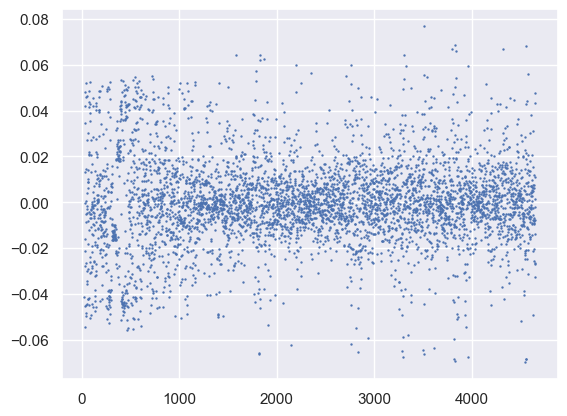

In [14]:
plt.scatter(X_trimmed.index ,ols_model.resid, s=0.5)

Text(0.5, 1.0, 'FPT stock return')

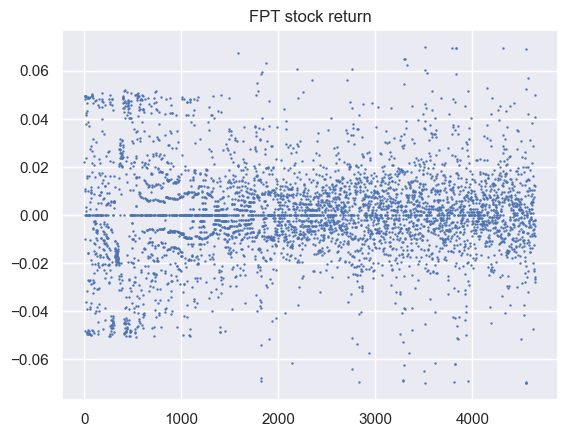

In [15]:
plt.scatter(df.index, df['return'], s=0.5)
plt.title('FPT stock return')

Residuals has the same value with return, the model basicly the same as base line model (white noise) and cannot detect variance at all.

Use ARCH/GARCH model to detect volatility.

c, MA(q) model and ARMA(p, q)

- MA: Current return is a weighted average of recent shocks.
- However, mean is close to 0 which make the results of MA(q) and ARMA(p, q) likely to be the same as AR model.

e, Conclusion

- Modeling return is inappropriate, this is true due to unmet assumptions.

#### **V. Volatility models**

0. Baseline

In [16]:
var_bl

np.float64(0.00036864673674661145)

In [17]:
bl_loss = qlike(df['return'].iloc[3000:], var_bl) # Test on recent
bl_loss

np.float64(2.6131200734914763)

1. ARCH(q)

In [18]:
# Configs
q = 32
lr = 0.0000001
epochs = 1000

In [19]:
# ARCH - manually derived
train_loss_list1 = []
val_loss_list1 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_01 = ARCH_MD(q, epochs, lr)
    arch_01.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_01.train_loss[-1]
    val_loss = arch_01.val_loss[-1]
    train_loss_list1.append(train_loss)
    val_loss_list1.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list1).mean():.2f} - Val loss: {np.asarray(val_loss_list1).mean():.2f}')

Train loss: 1.70 - Val loss: 1.56


In [20]:
# ARCH log - manually derived
train_loss_list2 = []
val_loss_list2 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_02 = ARCH_MD(q, epochs, lr, log='log')
    arch_02.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_02.train_loss[-1]
    val_loss = arch_02.val_loss[-1]
    train_loss_list2.append(train_loss)
    val_loss_list2.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list2).mean():.2f} - Val loss: {np.asarray(val_loss_list2).mean():.2f}')

Train loss: 1.67 - Val loss: 2.00


In [21]:
# ARCH hybrid - manually derived
train_loss_list3 = []
val_loss_list3 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_03 = ARCH_MD(q, epochs, lr=0.00001, log='hybrid')
    arch_03.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_03.train_loss[-1]
    val_loss = arch_03.val_loss[-1]
    train_loss_list3.append(train_loss)
    val_loss_list3.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list3).mean():.2f} - Val loss: {np.asarray(val_loss_list3).mean():.2f}')

Train loss: 1.75 - Val loss: 0.97


In [22]:
# ARCH - scipy optimizer

In [23]:
# ARCH - auto differential

In [24]:
coefs = arch_02.summary()
coefs.head(7)

,coef value
lag20,0.056513
lag2,0.051242
lag5,0.044073
lag18,0.036568
lag1,0.035575
lag15,0.034489
lag25,0.034152


Text(0.5, 0, 'Coef value')

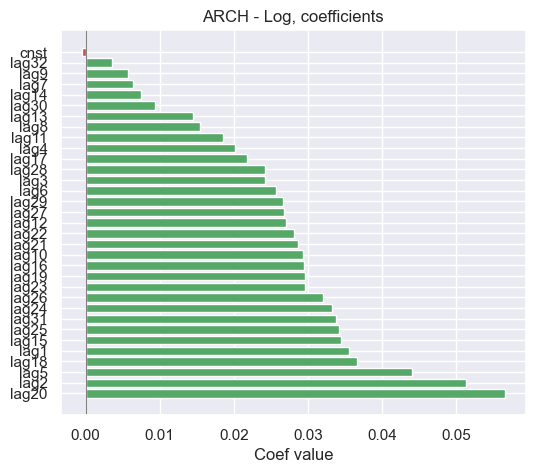

In [25]:
plt.figure(figsize=(6, 5))
colors = ['g' if c > 0 else 'r' for c in coefs['coef value']]
plt.barh(y=coefs.index, width=coefs['coef value'], color=colors)
plt.title("ARCH - Log, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

Constant level close to 0 indicate a close to 1 scale to the imapact of the past shock (Low impact of constant).

2.  GARCH(p, q)

In [26]:
# Configs
p = 30
q = 32
epochs = 1000
lr = 0.001

In [27]:
# GARCH - manually derived
train_loss_list4 = []
val_loss_list4 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    garch_01 = GARCH_MD(q, p, epochs, lr)
    garch_01.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = garch_01.train_loss[-1]
    val_loss = garch_01.val_loss[-1]
    train_loss_list4.append(train_loss)
    val_loss_list4.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list4).mean():.2f} - Val loss: {np.asarray(val_loss_list4).mean():.2f}')

Train loss: 1.60 - Val loss: 1.09


Text(0.5, 0, 'Coef value')

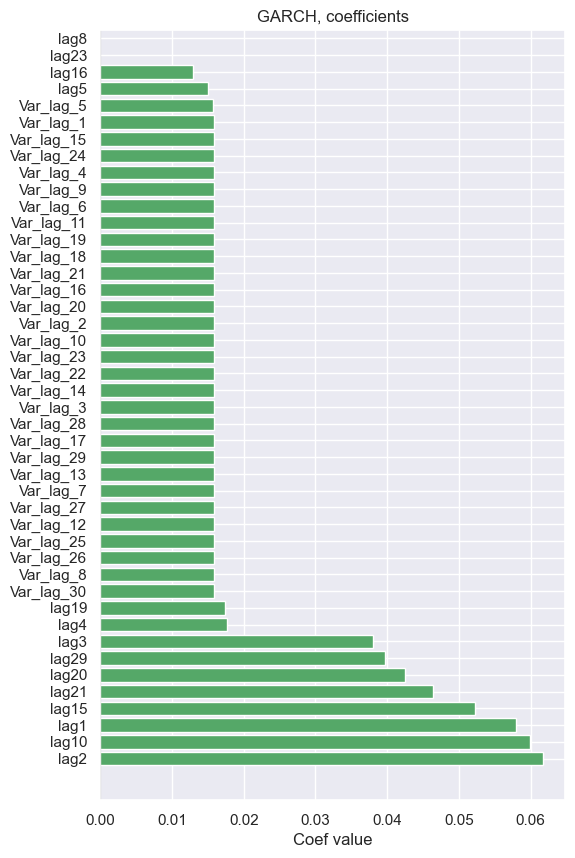

In [28]:
garch_coef = garch_01.summary()
garch_coef = garch_coef[garch_coef >= 0.01]
plt.figure(figsize=(6, 10))
colors = ['g' if c > 0 else 'r' for c in garch_coef['coef value']]
plt.barh(y=garch_coef.index, width=garch_coef['coef value'], color=colors)
plt.title("GARCH, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

Impact lies across all lag.

In [29]:
# GARCH - auto differential

3. Choosing model

In [30]:
# Compare model
comparision = {
    'baseline'  : [bl_loss]*2 + [np.nan] * len(train_loss_list1 + val_loss_list1),
    'ARCH - lin': [np.asarray(train_loss_list1).mean(), np.asarray(val_loss_list1).mean()] + train_loss_list1 + val_loss_list1,
    'ARCH - log': [np.asarray(train_loss_list2).mean(), np.asarray(val_loss_list2).mean()] + train_loss_list2 + val_loss_list2,
    'ARCH - hybrid': [np.asarray(train_loss_list3).mean(), np.asarray(val_loss_list3).mean()] + train_loss_list3 + val_loss_list3,
    'GARCH': [np.asarray(train_loss_list4).mean(), np.asarray(val_loss_list4).mean()] + train_loss_list4 + val_loss_list4,
    }

metrics = ['avg_train_qlike', 'avg_val_qlike'] + [f'fold_{f+1}_train_qlike' for f in range(len(train_loss_list1))] + [f'fold_{f+1}_val_qlike' for f in range(len(val_loss_list1))]

comparision_df = pd.DataFrame(comparision, index=metrics)
comparision_df.T.sort_values(by=['avg_train_qlike', 'avg_val_qlike'], ascending=True)

,avg_train_qlike,avg_val_qlike,fold_1_train_qlike,fold_2_train_qlike,fold_3_train_qlike,fold_1_val_qlike,fold_2_val_qlike,fold_3_val_qlike
GARCH,1.600352,1.085911,1.528699,1.755306,1.517051,0.651469,2.462139,0.144124
ARCH - log,1.671378,1.997587,1.640674,1.829667,1.543792,2.939235,2.917617,0.135909
ARCH - lin,1.699064,1.563581,1.617630,1.835400,1.644161,1.821694,2.720532,0.148517
ARCH - hybrid,1.752016,0.974489,1.695841,1.896444,1.663763,1.292769,1.584367,0.046331
baseline,2.613120,2.613120,NaN,NaN,NaN,NaN,NaN,NaN


Choose GARCH as final volatiltiy model.

4. Retrain model

In [31]:
# Configs
p = 30
q = 32
epochs = 500
lr = 0.004

In [32]:
fin_vol_model = GARCH_MD(q, p, epochs, lr)
fin_vol_model.fit(df['return'].iloc[:3500], df['return'].iloc[3500:], verbose=0, stopstep=5)

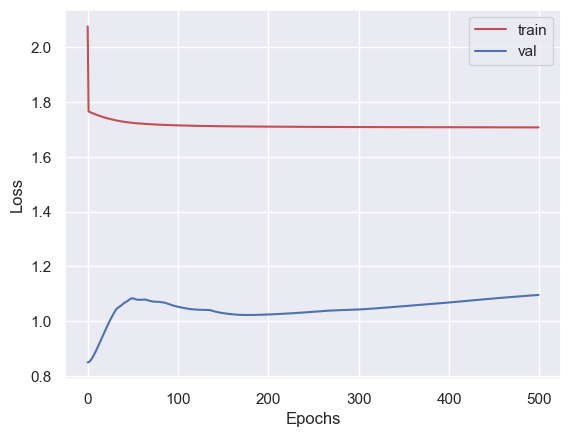

In [33]:
plt.plot(fin_vol_model.train_loss, color='r', label='train')
plt.plot(fin_vol_model.val_loss, color='b', label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [34]:
fin_vol_model = GARCH_MD(q, p, epochs=155, lr=lr)
fin_vol_model.fit(df['return'].iloc[:3500], df['return'].iloc[3500:], verbose=0, stopstep=5)

In [35]:
fin_coef = fin_vol_model.summary()

Text(0.5, 0, 'Coef value')

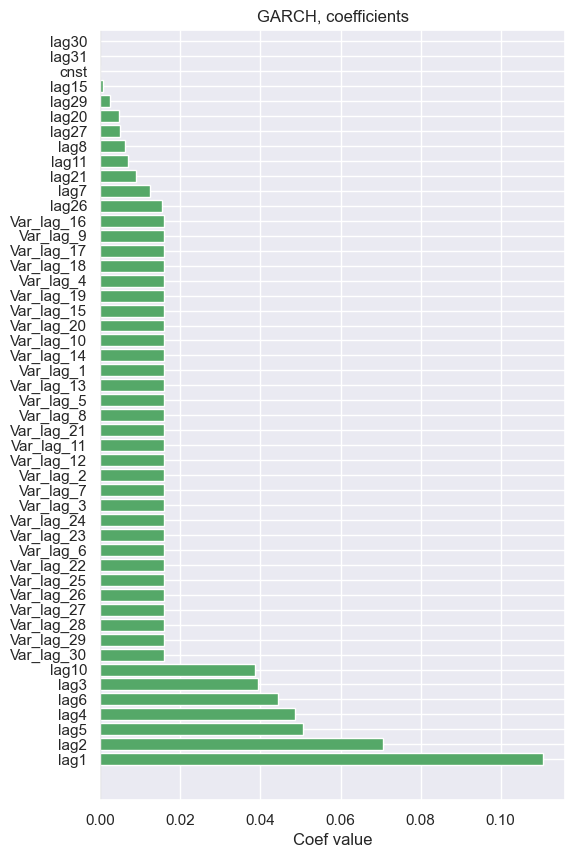

In [36]:
fin_coef = fin_coef[fin_coef > 0]
plt.figure(figsize=(6, 10))
colors = ['g' if c > 0 else 'r' for c in fin_coef['coef value']]
plt.barh(y=fin_coef.index, width=fin_coef['coef value'], color=colors)
plt.title("GARCH, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

#### **VII. Decision bot**

In [61]:
# Config
cash_original = 3000
number_of_shares_original = 0
p_price = 10
p_var = 32

discount_rate = 0.4
risk_adverse_factor = 1.2 # Risk adverse person
risk_adverse_factor_2 = 0.8 # Risk tolerance person

explore_rate = 0.7
decay_rate = 0.998 # At epoch 340, explore rate is around 0.5 => Moving to exploit more than explore

lr = 0.01
epochs = 10000
batch_size = 60 # Change behavior after 2 month

action_list = [1, 5, 10, -1, -5, -10, 0] # 0 mean hold, 1 at index 0 to make sure non random at initialization make some action

In [62]:
# Predict volatility
var_estimate = pd.Series(fin_vol_model.predict(df['return'].iloc[3000:], include_past_estimate=True)[:-1]).reset_index(drop=True)
consider_df = df.iloc[3000:].reset_index(drop=True)

In [63]:
# Decision model on price and volatility
decision = price_volatility(risk_adverse_factor, cash_original, p_price, number_of_shares_original, discount_rate, explore_rate, decay_rate, lr, epochs, action_list, batch_size, p_var=p_var)
decision.fit(consider_df, var_estimate, verbose=0)

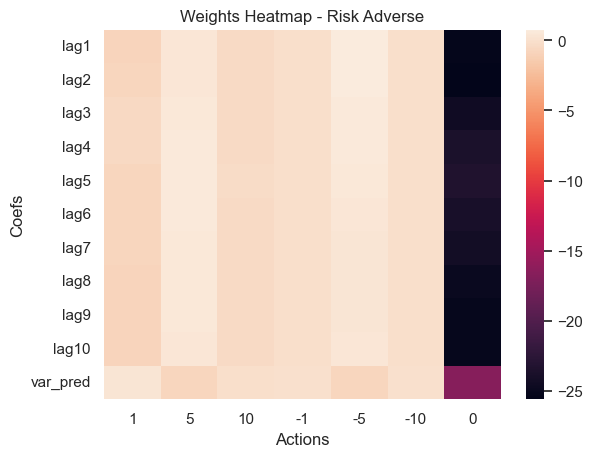

In [64]:
sns.heatmap(decision.W.rename(columns = dict(zip([i for i in range(len(action_list))], action_list)))/1e4)
plt.title('Weights Heatmap - Risk Adverse')
plt.xlabel('Actions')
plt.ylabel('Coefs')
plt.show()

In [65]:
decision_TC = decision.final_capital_list
decision_cash = decision.cash_list
decision_shares = decision.shares_list

Text(0, 0.5, 'Total final capital')

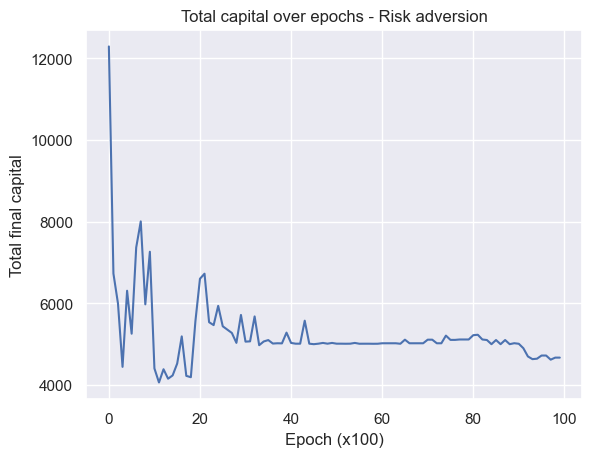

In [66]:
plt.plot(decision_TC[::100])
plt.title('Total capital over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Total final capital')

Text(0, 0.5, 'Final cash (thousand VND)')

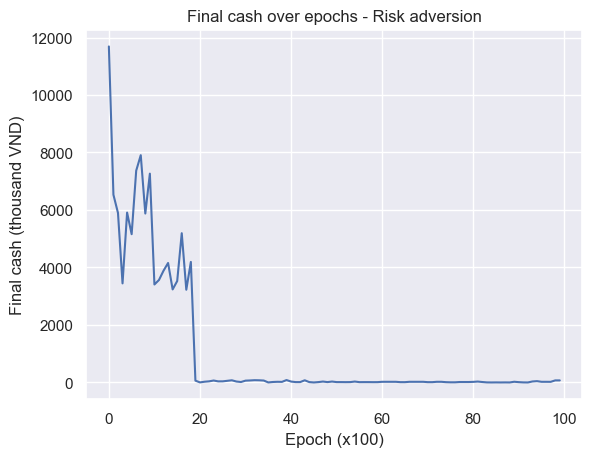

In [67]:
plt.plot(decision_cash[::100])
plt.title('Final cash over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final cash (thousand VND)')

Text(0, 0.5, 'Final shares')

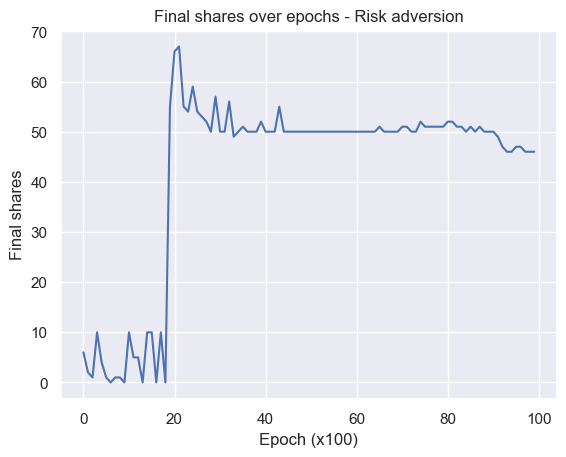

In [68]:
plt.plot(decision_shares[::100])
plt.title('Final shares over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final shares')

In [69]:
# Decision model on price and volatility
decision2 = price_volatility(risk_adverse_factor_2, cash_original, p_price, number_of_shares_original, discount_rate, explore_rate, decay_rate, lr, epochs, action_list, batch_size, p_var=p_var)
decision2.fit(consider_df, var_estimate, verbose=0)

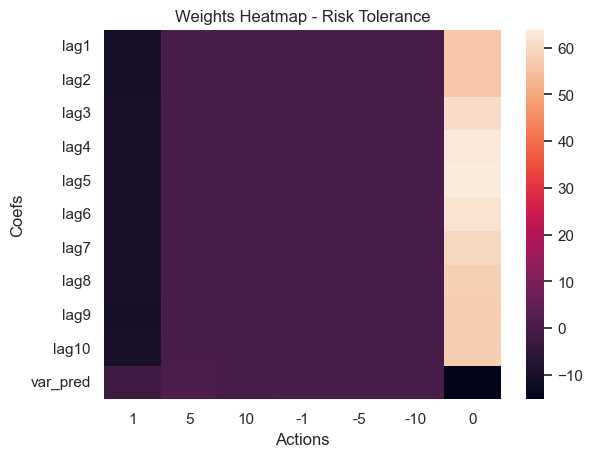

In [70]:
sns.heatmap(decision2.W.rename(columns = dict(zip([i for i in range(len(action_list))], action_list)))/1e4)
plt.title('Weights Heatmap - Risk Tolerance')
plt.xlabel('Actions')
plt.ylabel('Coefs')
plt.show()

In [72]:
decision_TC2 = decision2.final_capital_list
decision_cash2 = decision2.cash_list
decision_shares2 = decision2.shares_list

Text(0, 0.5, 'Total final capital')

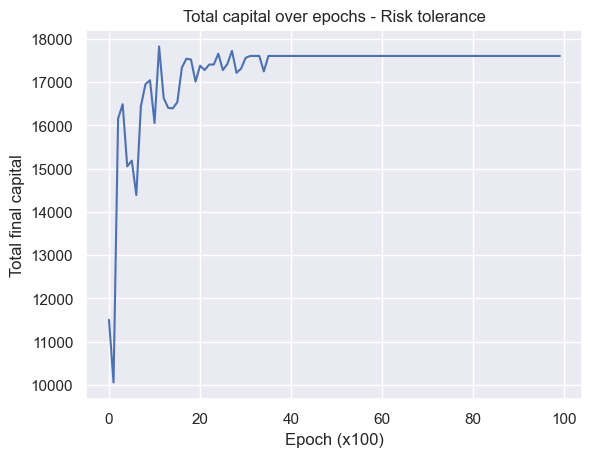

In [73]:
plt.plot(decision_TC2[::100])
plt.title('Total capital over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Total final capital')

Text(0, 0.5, 'Final cash (thousand VND)')

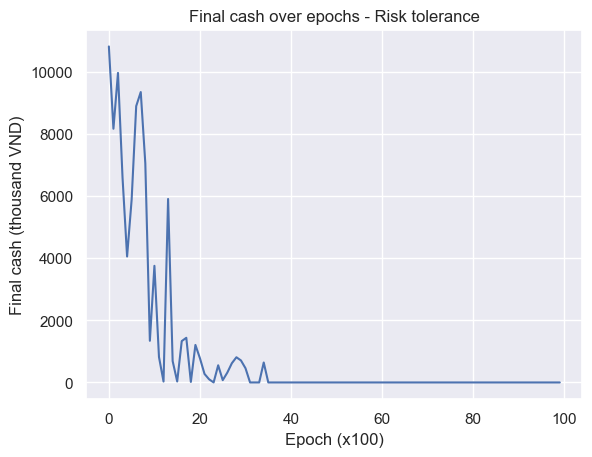

In [74]:
plt.plot(decision_cash2[::100])
plt.title('Final cash over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final cash (thousand VND)')

Text(0, 0.5, 'Final shares')

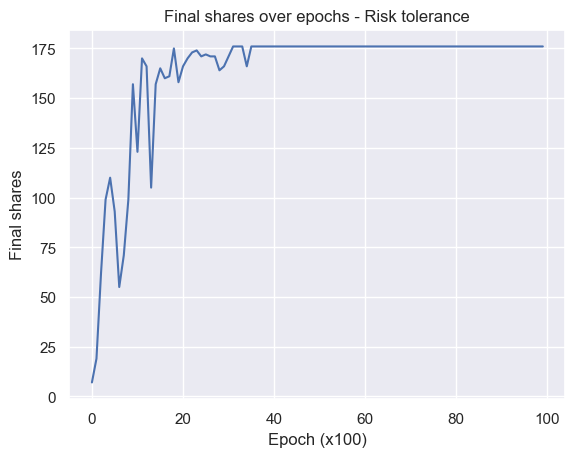

In [75]:
plt.plot(decision_shares2[::100])
plt.title('Final shares over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final shares')